In [1]:
%%html
<style>
table {float:left}
</style>

# Objective

Implement the YouTube video [Special Topics - The Kalman Filter](https://www.youtube.com/watch?v=Fuy73n6_bBc) by professor Michel van Biezen.

* [Special Topics - The Kalman Filter (28 of 55) 2. Initial Process Covariance - Tracking Airplane](https://www.youtube.com/watch?v=Fuy73n6_bBc&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=27)

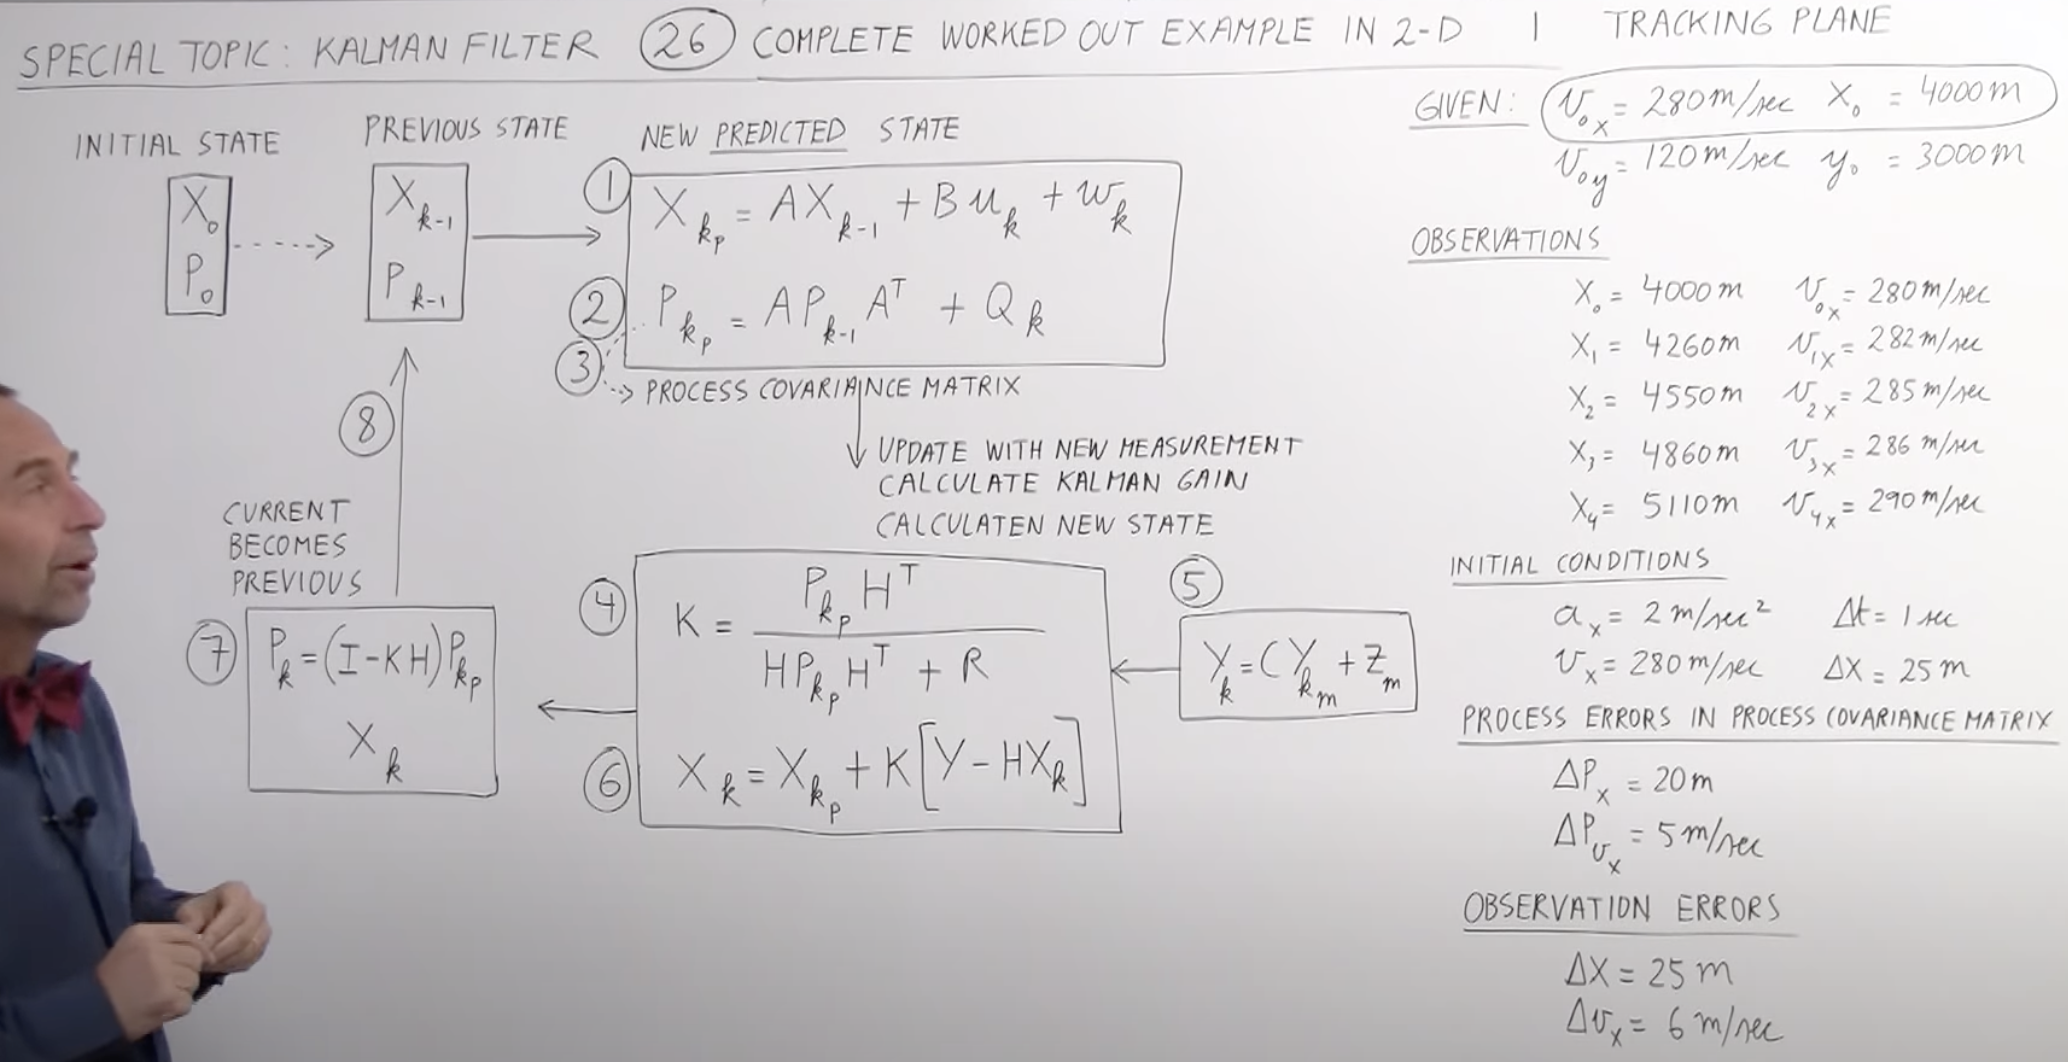



$$
\begin {align}
A &= \begin {bmatrix}
    1 & \Delta t \\
    0 & 1
\end {bmatrix}
\\
B &= \begin {bmatrix}
    \frac {\Delta t^2}{2} \\
    \Delta t
\end {bmatrix}
\\
H &= I
\\
s_k &= \begin {bmatrix}
    x_{k} \\
    v_{k}
\end {bmatrix} =
A
\begin {bmatrix}
    x_{k-1} \\
    v_{k-1}
\end {bmatrix}
+ B a
\\
P_k &= 
A 
\begin {bmatrix}
    \sigma_{xk}^2 & \sigma_{xk} \sigma_{vk} \\
    \sigma_{vk} \sigma_{xk} & \sigma_{vk}^2
\end {bmatrix}
A^T
\end {align}
$$

---

## Terms

$x_k$: position of the object at time ```k``` with $\sigma_x^2$ variance of uncertainty.

$v_k$: speed of the object with $\sigma_v^2$ variance of uncertainty.

$y_k$: measurement of the process state $(x_k, v_k)$

$a$: constant acceralation

$A$: Process Transition Matrix that represents the model to predict the next process state $x_k$

$B$: Control Matrix

$C$: Projection Matrix to map the measurement $y_k$ into the multi-dimensional space of Kalman Filter calculation.

$H$: Measurement Transformation Matrix that maps the process state to the observation space. 

> Since the process state space ```s``` and the observation space ```y``` are the same 3D air space in thie example, H = Identity I.

$P_k$: Process Error Covariance Matrix representing the uncertainty expected in the process.

$R$: Measurement Error Covariance Matrix representing the uncertainty expected in the measurement. 

> ```R``` is fixed as it is usually known e.g. provided by the manufacturer of the measurement devices. 


In [50]:
from typing import (
    List,
    Dict,
    Tuple,
    Optional,
    Union,
    Any,
)

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

---
# Initialisation

## Process State

### Position $x_{k-1}$

In [3]:
x_0 = 4000

### Speed $v_{k-1}$

In [4]:
v_0 = 280

In [5]:
s_0 = np.array([x_0, v_0]).T
s_0

array([4000,  280])

## Control Variables

### Acceleration $a_{k-1}$

In [6]:
a_0 = 2

### Interval $\Delta t$

In [7]:
dt = 1

## Process Estimate Errors $\sigma_x^2$ and $\sigma_v^2$

In [8]:
sigma_x = 20
var_x = sigma_x **2

In [9]:
sigma_v = 5
var_v = sigma_v ** 2

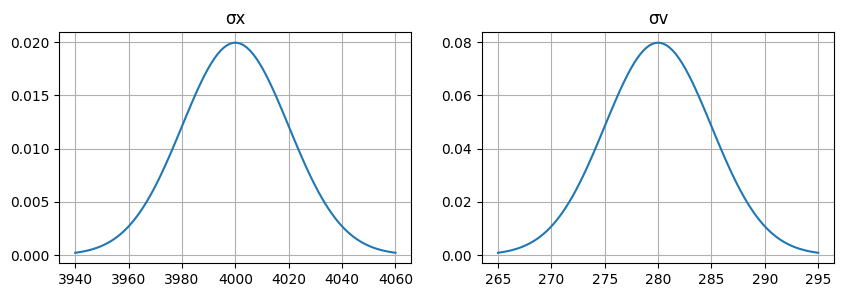

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

_ = np.linspace(x_0 - 3*sigma_x, x_0 + 3*sigma_x, 100)
axes[0].title.set_text('σx')
axes[0].plot(_, stats.norm.pdf(_, x_0, sigma_x))
axes[0].grid()

_ = np.linspace(v_0 - 3*sigma_v, v_0 + 3*sigma_v, 100)
axes[1].title.set_text('σv')
axes[1].plot(_, stats.norm.pdf(_, v_0, sigma_v))
axes[1].grid()

### Process Error Covariance

* [Special Topics - The Kalman Filter (28 of 55) 2. Initial Process Covariance - Tracking Airplane](https://www.youtube.com/watch?v=Jm6OIadu6FY&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=29)

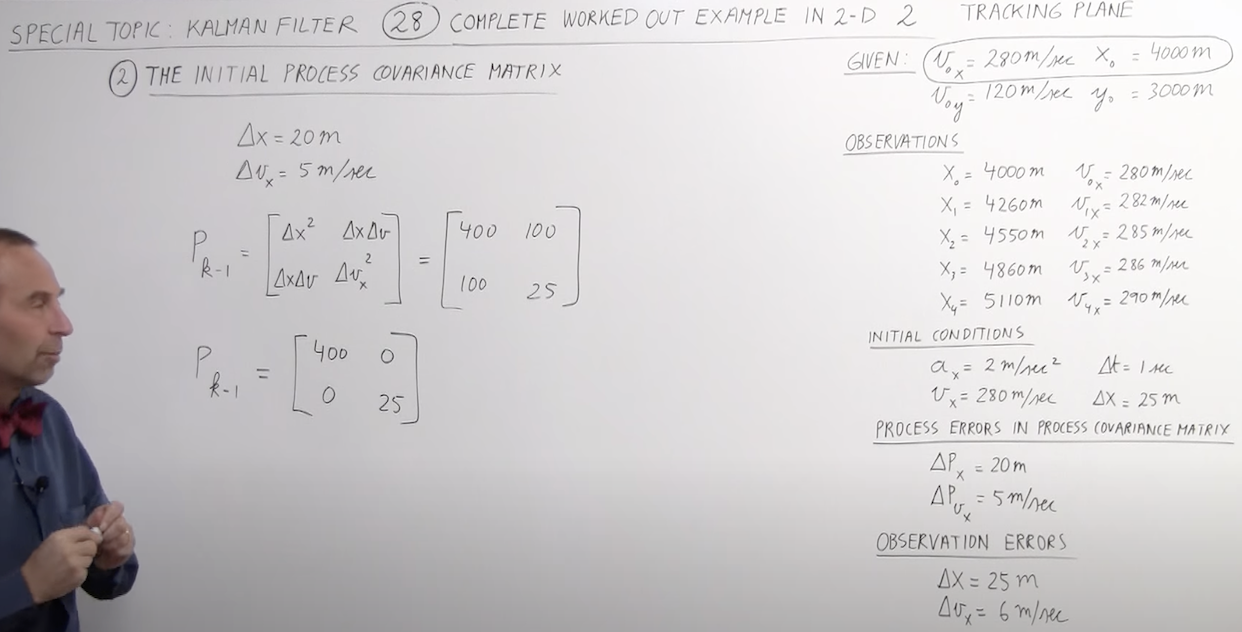

In [11]:
P_0 = np.array([
    [var_x, sigma_x * sigma_v],
    [sigma_v * sigma_x, var_v]
])
P_0

array([[400, 100],
       [100,  25]])

Simplify the process error covariance by regarding no correlation between $x$ and $v$. 

In [12]:
P_0 = np.diag(np.diag(P_0))
P_0

array([[400,   0],
       [  0,  25]])

## Measurement Error Covariance 

In [13]:
sigma_m_x = 25
var_m_x = sigma_m_x **2

In [14]:
sigma_m_v = 6
var_m_v = sigma_m_v ** 2

In [15]:
R = np.array([
    [var_m_x, sigma_m_x * sigma_m_v],
    [sigma_m_v * sigma_m_x, var_m_v]
])
R

array([[625, 150],
       [150,  36]])

Simplify the measurement error covariance by regarding no correlation between $m_x$ and $m_v$. 

In [16]:
R = np.diag(np.diag(R))
R

array([[625,   0],
       [  0,  36]])

---
# Process Transition

In [17]:
A = np.array([
    [1, dt],
    [0, 1]
])
A

array([[1, 1],
       [0, 1]])

In [18]:
B = np.array([dt**2 / 2, dt])
B

array([0.5, 1. ])

# Measurement Transformation

In [19]:
H = np.identity(n=2)
H

array([[1., 0.],
       [0., 1.]])

---

# State Estimate 

[How a Kalman filter works, in pictures](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)

<img src="kalman_gain.png" align="left" width=650 />

## k = 1

### Process Error

In [20]:
_P_hat = A @ P_0 @ A.T
_P_hat

array([[425,  25],
       [ 25,  25]])

Simplified again the new process uncertainty covariance matrix by regarding no correlation between $x$ and $v$. 

In [21]:
_P_hat = np.diag(np.diag(_P_hat))
_P_hat

array([[425,   0],
       [  0,  25]])

### Kalman Gain $K_g = \frac {\hat {P} H^T } {(H \hat {P} H^T + R)}$

* [Special Topics - The Kalman Filter (30 of 55) 4. Calculate the Kalman Gain - Tracking Airplane](https://www.youtube.com/watch?v=8eqopG4q9Ew&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=31)

<img src="kalman_gain_calc.png" align="left"/>

In [22]:
PE: np.ndarray = _P_hat @ H.T   # Process Error
ME: np.ndarray = R              # Measurement Error
KG = PE @ np.linalg.inv(H@_P_hat@H.T + ME)
np.round(KG, 3)

array([[0.405, 0.   ],
       [0.   , 0.41 ]])

## Projection Matrix $C$

The shape of C is the same with KG.

In [23]:
C = np.identity(KG.ndim)
C

array([[1., 0.],
       [0., 1.]])

### Measurement

In [24]:
y_1 = C @ np.array([4260, 282])
y_1

array([4260.,  282.])

### Posterior Process State

$
\begin {align}
\hat {s} &= Az_{k-1} + Ba \\
s_k &= \hat {s} + K_G(y_k - H \hat {s})
\end {align}
$


In [25]:
_s_hat = np.dot(A, s_0) + np.dot(B, a_0)
s_1 = _s_hat + KG @ (y_1 - H @ _s_hat)
x_1, v_1 = s_1
print(f"Posterior process state (x_k, y_k) = {(x_1, v_1)}")

Posterior process state (x_k, y_k) = (4272.5, 282.0)


### Posterior Process Error Covariance

$
P_k = \hat {P} - K_G H \hat {P}
$

* [Special Topics - The Kalman Filter (33 of 55) 7. Update Process Covariance - Tracking Airplane](https://www.youtube.com/watch?v=JaFrOn0zf50&list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT&index=34)

<img src="process_error_covariance_calc.png" align="left"/>

In [26]:
P_1 = _P_hat - KG @ H @ _P_hat
np.round(P_1, 2)

array([[252.98,   0.  ],
       [  0.  ,  14.75]])

---
# Iteration

In [36]:
def kalman_filter(
    s: np.ndarray,
    P: np.ndarray,
    A: np.ndarray,
    B: np.ndarray,
    u: np.ndarray,
    H: np.ndarray,
    C: np.ndarray,
    y: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    s: current process state,
    P: current process error covariance matrix
    A: Process transition matrix,
    B: Control matrix
    u: control vector
    H: Measurement transformation matrix
    C: Measurement projection matrix
    y: measurement
    """
    # --------------------------------------------------------------------------------
    # Process error covariance transition
    # --------------------------------------------------------------------------------
    # de-correlate process state elements to simplify.
    P = np.diag(np.diag(P))
    _P_hat = A @ P @ A.T
    
    # de-correlate process state elements to simplify.
    _P_hat = np.diag(np.diag(_P_hat))
        
    # --------------------------------------------------------------------------------
    # Kalman Gain
    # --------------------------------------------------------------------------------
    PE: np.ndarray = _P_hat @ H.T   # Process Error
    ME: np.ndarray = R              # Measurement Error
    KG = PE @ np.linalg.inv(H@_P_hat@H.T + ME)
    print(f"KG is \n{KG}")

    # --------------------------------------------------------------------------------
    # Project measurement into KG space
    # --------------------------------------------------------------------------------
    y_projected = C @ y
    
    # --------------------------------------------------------------------------------
    # Posterior Process State
    # --------------------------------------------------------------------------------
    # Next process state prediction by A
    _s_hat = np.dot(A, s) + np.dot(B, u)

    # posterior for s via kalman gain
    s_next = _s_hat + KG @ (y_projected - H @ _s_hat)

    # posterior for P via kalman gain
    P_next = _P_hat - KG @ H @ _P_hat
    
    s_predicted = _s_hat
    s_actual = y
    
    return s_next, P_next, s_predicted, s_actual

In [37]:
s_current = np.array([x_0, v_0]).T
a = 2
P_current = np.diag(np.diag(P_0))

Y = np.array([
    [4260, 282],
    [4550, 285],
    [4860, 286],
    [5110, 290],
])
results = []

In [38]:
for index, y in enumerate(Y):
    print("-"*80)
    print(index)
    print("-"*80)

    s_current, P_current, s_predicted, s_actual = kalman_filter(
        s=s_current,
        P=P_current,
        A=A,
        B=B,
        u=a,
        H=H,
        C=C,
        y=y
    )
    results.append((s_current, P_current, s_predicted, s_actual))
    print(f"current state (x, v)={s_current}")
    print(f"current error (x, v)={(np.sqrt(P_current)[0,0], np.sqrt(P_current)[1,1])}")

--------------------------------------------------------------------------------
0
--------------------------------------------------------------------------------
KG is 
[[0.4047619  0.        ]
 [0.         0.40983607]]
current state (x, v)=[4272.5  282. ]
current error (x, v)=(15.905225257008794, 3.8411063979868794)
--------------------------------------------------------------------------------
1
--------------------------------------------------------------------------------
KG is 
[[0.29990053 0.        ]
 [0.         0.29069767]]
current state (x, v)=[4553.85054707  284.29069767]
current error (x, v)=(13.690793720509477, 3.2349831961031525)
--------------------------------------------------------------------------------
2
--------------------------------------------------------------------------------
KG is 
[[0.24049367 0.        ]
 [0.         0.22522523]]
current state (x, v)=[4844.15764332  286.22522523]
current error (x, v)=(12.260038449385746, 2.847473987257497)
----------

In [39]:
s_current, P_current

(array([5127.05898493,  288.55147059]),
 array([[126.38282157,   0.        ],
        [  0.        ,   6.61764706]]))

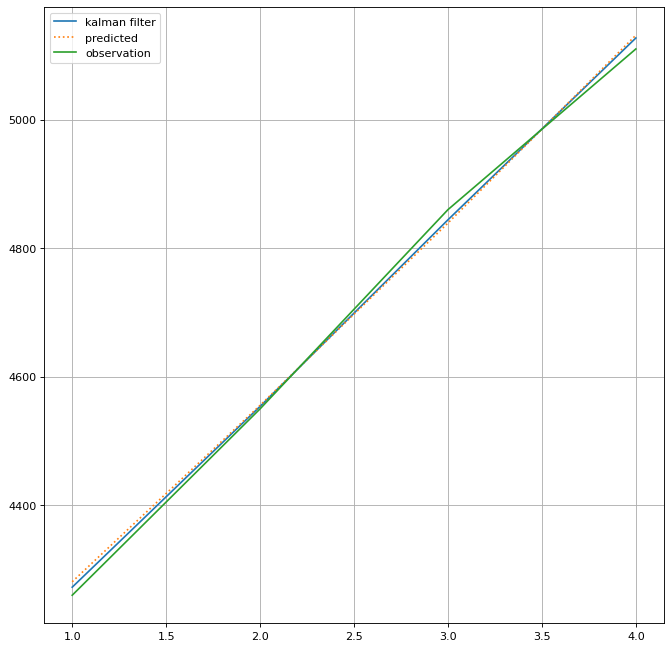

In [53]:
figure(figsize=(10, 10), dpi=80)

plt.plot(range(1, len(Y)+1), [r[0][0] for r in results], label="kalman filter")
plt.plot(range(1, len(Y)+1), [r[2][0] for r in results], label="predicted", linestyle='dotted')
plt.plot(range(1, len(Y)+1), [r[3][0] for r in results], label="observation")
plt.legend(loc="upper left")
plt.grid()
plt.show()
